In [13]:
import itertools, pickle, PIL.Image
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

In [14]:
FILENAME = "/Users/James/Documents/PSY6431/data/images/kingfisher-1905255_640.jpg" # Kingfisher

In [15]:
def crop_img(img, window, offset):
    img = np.array(img)

    x = img.shape[1]
    y = img.shape[0]
    
    x1 = int((x - window[0] + offset[0])/2)
    x2 = int((x + window[0] + offset[0])/2)
    y1 = int((y - window[1] + offset[1])/2)
    y2 = int((y + window[1] + offset[1])/2)

    return PIL.Image.fromarray(img[y1:y2,x1:x2])

In [16]:
class LAM():
    def __init__(self, N, P, prob, H, gamma, normalize):
        self.initialize(N, P, prob, H, gamma, normalize)

    def _step(self,z):
        return 0.5 * np.sign(z) + 0.5

    def _set_weight(self,a):
        if self.norm_mode == "sym":
            self.W = a * self.Wauto + self.Whetero - (a+1) * self.WG
        elif self.norm_mode == "asym":
            self.W = a * self.Wauto + self.Whetero - (a+1) * self.WG

    def initialize(self, N, P, prob, H, gamma, normalize):
        self.N = N
        self.P = P
        self.prob = prob
        self.H = H
        self.gamma = gamma
        self.V = self.prob * (1-self.prob)
        self.norm_mode = normalize

        # Normalization
        if self.norm_mode == "sym":
            Dnorm = np.diag(np.sum(self.H, axis=1)**-0.5)
            self.H = Dnorm @ self.H @ Dnorm
        elif self.norm_mode == "asym":
            Dnorm = np.diag(np.sum(self.H, axis=1)**-1)
            self.H = Dnorm @ self.H
        else:
            print("Error: Normalization mode sym or asym was not specified.")
            exit()
        
        # Generate patterns
        self.xi = (np.random.rand(self.N, self.P) < self.prob).astype(np.float)
        self.xi_mean = np.sum(self.xi, axis=1, keepdims=True) / self.P
        self.xi_bias = self.xi - self.xi_mean

        # Weights
        if self.norm_mode == "sym":
            self.Wauto = (self.xi_bias @ self.xi_bias.T) / (self.N * self.V)
            self.Whetero = (self.xi_bias @ self.H @ self.xi_bias.T) / (self.N * self.V)
            self.WG = self.gamma / self.N
        elif self.norm_mode == "asym":
            self.Wauto = (self.xi @ self.xi.T) / (self.N*self.V)
            self.Whetero = (self.xi @ self.H @ self.xi.T) / (self.N*self.V)
            self.WG = self.P * self.xi_mean @ self.xi_mean.T / (self.N*self.V) + self.gamma / self.N

    def simulate_single(self, a, eta, simlen, start_node, energycheck=True):
        self._set_weight(a)

        # Simulation
        self.x = self.xi[:,start_node] + 0.0
        self.m_log = np.zeros([simlen, self.P])
        self.obj_log = np.zeros([simlen])
        for t in range(simlen):
            if t%100 == 0:
                print(t)
            
            self.r = self._step(self.W @ self.x)
            self.x += eta*(self.r - self.x)
            self.m = (self.xi_bias.T @ self.x) / (self.N*self.V)
            self.m_log[t,:] = self.m
            if energycheck:
                self.obj_log[t] = -(self.x).T @ self.W @ self.x / (self.N * self.V)

        return (self.m_log, self.obj_log)

---

#### PROCESS IMAGE

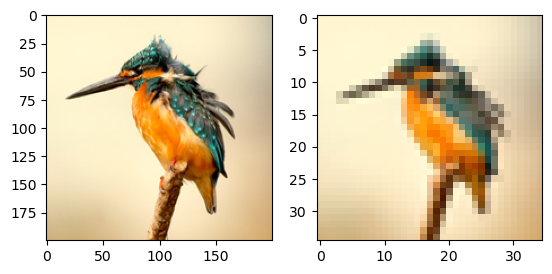

In [17]:
img = PIL.Image.open(FILENAME)

img_cropped = crop_img(img, (200, 200), (130, 40))
# img_cropped.save("cropped.jpg")
plt.subplot(1,2,1)
plt.imshow(img_cropped)

img_resized = img_cropped.resize((35, 35))
# img_resized.save("resized.jpg")
plt.subplot(1,2,2)
plt.imshow(img_resized)

---

#### CREATE NETWORK FROM IMAGE (Resized)

Nnode= 1225 Nedge= 37010


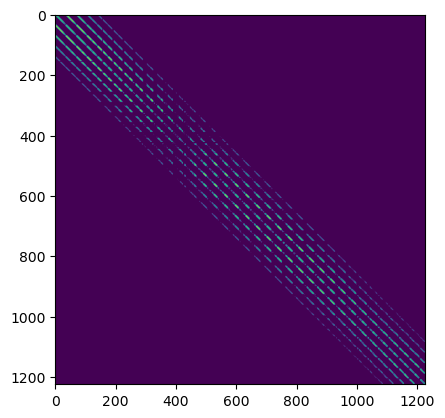

In [18]:
img = np.array(img_resized, dtype=float) / np.max(img_resized) # Normalised input matrix

n_row = img.shape[0]
n_col = img.shape[1]
N = n_row * n_col # N_units

sigmaI = 0.1
sigmaX = 4.0
r = 5

tmp = itertools.product(range(n_row), range(n_col))
combi_all = itertools.combinations(tmp, 2)
combi = [x for x in combi_all if np.sqrt((x[0][0] - x[1][0])**2 + (x[0][1] - x[1][1])**2) < r]

edgelist_w = []
for x1,x2 in combi:
    n1 = int(x1[0] * n_col + x1[1])
    n2 = int(x2[0] * n_col + x2[1])
    simval = np.exp(-np.sum((img[x1[0], x1[1]] - img[x2[0], x2[1]])**2) / (sigmaI**2)) * np.exp(-((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2) / (sigmaX**2))
    edgelist_w.append((n1, n2, simval))

#Adjacency matrix
W = np.zeros([N, N])
for x in edgelist_w:
    W[x[0],x[1]] = x[2]
    W[x[1],x[0]] = x[2]

print("Nnode=", N, "Nedge=", len(edgelist_w))
plt.imshow(W)

#numpy.savetxt("edgelist_weight.csv", edgelist_w, delimiter=",")
# np.savetxt("adjacency.csv", W, delimiter=",")

---

#### GRAPH LAPLACIAN

In [19]:
P = W.shape[0] # Adjacency Matrix

Dnorm = np.diag(np.sum(W,axis=1)**-1) # Normalize

# Laplacian
L = np.eye(P) - Dnorm @ W
e, v = scipy.linalg.eig(L)

# Eigenval
e = np.real(e)
v = np.real(v)

order = np.argsort(e)
e = e[order]
v = v[:,order]

# np.savetxt("eigenval.csv", e, delimiter=",")
# np.savetxt("eigenvec.csv", v, delimiter=",")

---

#### SIM IMAGE

In [20]:
figsize = np.array(img_resized).shape[:2]
normalize = "asym" # Mode

# Network simulation
N = 30000
prob = 0.1
eta = 0.01
simlen = 3000
gamma = 0.6
a_arr = np.arange(-1.5, 3.1, 0.1)

start_node = int(int(figsize[0]/2) * figsize[1] + int(figsize[1]/2))

a_hist = []
m_hist = []
obj_hist = np.zeros([len(a_arr), simlen])

In [23]:
network = LAM(N, P, prob, W, gamma, normalize)

/var/folders/d8/6x05bdw13yl63rk0v5qdndd40000gn/T/ipykernel_23146/2157264196.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.xi=(np.random.rand(self.N,self.P)<self.prob).astype(np.float)


In [ ]:
for a_ind in range(len(a_arr)):
    a = np.around(a_arr[a_ind],decimals=1)
    print(a, a_ind)
    break
    m_log, obj_log = network.simulate_single(a, eta, simlen, start_node)
    m = m_log[-1,:]

    a_hist.append(a)
    m_hist.append(m)
    save = (a_hist, m_hist)
    pickle.dump(save, open("results.pickle", "wb"))

    obj_hist[a_ind,:]=obj_log
    break

    # np.savetxt("objfunc.csv", obj_hist, delimiter=",")